In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
import pickle
import seaborn as sn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns; sns.set(style ='white', color_codes = True)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# Path of file to read
data_path = 'CollegeBasketballPlayers2009-2021.csv'
total_ball_data = pd.read_csv(data_path, low_memory = False)
total_ball_data = total_ball_data.drop(['ht', 'yr', 'num', 'pid', 'type', 'Rec Rank', 'gbpm', 'ogbpm', 'dgbpm', 'Unnamed: 64', 'Unnamed: 65'], axis=1)

Zmiana zmiennej objasnianej 'pick' na zmienna binarna i filtracja danych

In [3]:
#Przerabiam dane - zmienną objasniana pick przerabiam na binarną
total_ball_data["pick"] = total_ball_data["pick"].replace(np.nan, 0)
for i in range(len(total_ball_data)):
    if total_ball_data["pick"][i] >=1:
        total_ball_data["pick"][i]=1

total_ball_data['pick'] = total_ball_data['pick'].astype(int)

#filtruje przez te 3 kolumny zeby nie stracic zbyt duzej liczby zmiennych objasniajacych 
# w ten sposob tracę 9 a nie 34 zmiennych objasniajacych
total_ball_data =total_ball_data[total_ball_data['drtg'].notna()]
total_ball_data =total_ball_data[total_ball_data['ast'].notna()]
total_ball_data =total_ball_data[total_ball_data['dunksmade'].notna()]

total_ball_data['rimmade/(rimmade+rimmiss)'].fillna(0, inplace=True)
total_ball_data['midmade/(midmade+midmiss)'].fillna(0, inplace=True)
total_ball_data['dunksmade/(dunksmade+dunksmiss)'].fillna(0, inplace=True)
total_ball_data['ast/tov'].fillna(0, inplace=True)

total_ball_data = total_ball_data._get_numeric_data()

Filtracja po korelacjach

In [ ]:
corr = total_ball_data.corr()
high_corr = corr[(corr >= 0.95) & (corr < 1)]
#w sumie 19 zmiennych powyzej 0.95 jest skorelowanych
columns_to_remove = high_corr.columns[high_corr.any()]
# Drop the columns from the DataFrame
#print(columns_to_remove)
total_ball_data = total_ball_data.drop(columns_to_remove, axis=1)


Na danych do 2020 roku włącznie uczę model. Na danych z 2021 dokonam weryfikacji modelu. 

In [4]:
ball_data = total_ball_data.loc[total_ball_data['year'] < 2021]
ball_data = ball_data.drop(['year'], axis=1)
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
ball_data_2021 = ball_data_2021.drop(['year'], axis=1)
total_ball_data = total_ball_data.drop(['year'], axis=1)
#ball_data

In [5]:
def conf_matrix(val_y, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(val_y, pred_test)
    con_mat = pd.DataFrame(con_mat, index=['Not Drafted', 'Drafted'], columns=['Not Drafted', 'Drafted'])
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sn.set(font_scale=1.5)
    sn.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adding labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

Podzial na zbior treningowy i testowy

In [56]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['Min_per', 'ftr', 'pts', 'ORB_per', 'DRB_per', 'blk_per', 'stl_per', 'dporpag', 'porpag', 'AST_per', 'TO_per', 'FT_per']

X = ball_data.loc[:,ball_data.columns!='pick']

colnames=list(X)
#display(X)
#X = ball_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

The f1 score for the testing data: 0.28806983511154216
Class 0 weight (majority class): 0.51
Class 1 weight (minority class): 20.25


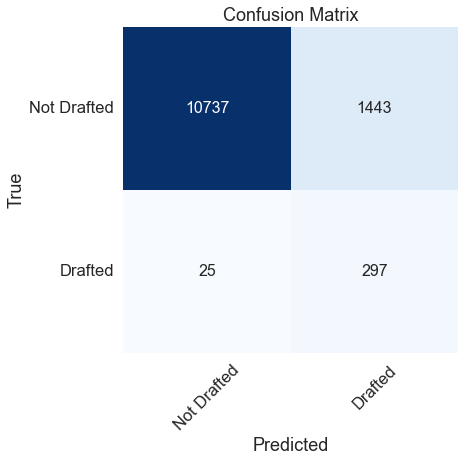

In [9]:
# create logistic regression model with balanced class weights
lr = LogisticRegression(solver='newton-cg')
model = LogisticRegression(solver='newton-cg', class_weight='balanced')

lr.fit(train_X, train_y)

# Make predictions on validation data
val_preds = lr.predict(val_X)

# Calculate F1 score on validation data
val_f1 = f1_score(val_y, val_preds)
recall = recall_score(val_y, val_preds)
precision = precision_score(val_y, val_preds)
# Print validation F1 score
print("Validation F1 score unbalanced: {:.2f}".format(val_f1))
print("Validation recall score unbalanced: {:,.5f}".format(recall))
print("Validation presision score unbalanced: {:,.5f}\n".format(precision))
# fit the model on the training data
model.fit(train_X, train_y)

# make predictions on the validation set
pred_test = model.predict(val_X)

# calculate f1 score and plot confusion matrix
f1_test = f1_score(val_y, pred_test)
print('The f1 score for the testing data:', f1_test)
# Calculate class weights for minority and majority classes
class_labels = [0, 1]  # Assuming 0 represents the majority class and 1 represents the minority class
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_y)

# Print class weights
print(f"Class 0 weight (majority class): {class_weights[0]:.2f}")
print(f"Class 1 weight (minority class): {class_weights[1]:.2f}")
conf_matrix(val_y, pred_test)


Validation f1 score: 0.13611
Validation recall score: 1.00000
Validation presision score: 0.07303


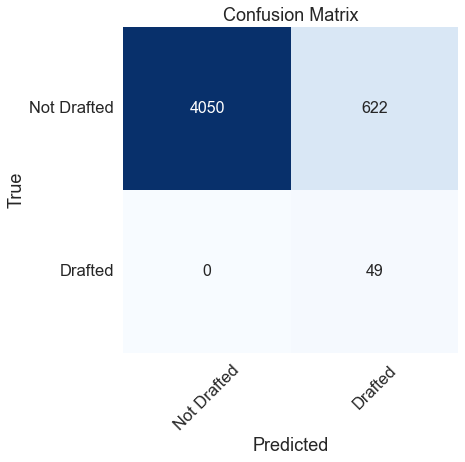

In [11]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

wykres z wagami dla 0 i 1

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Highest F1 Score: 0.47909899435914394
Weight for Class 1: 0.78
Weight for Class 2: 0.22


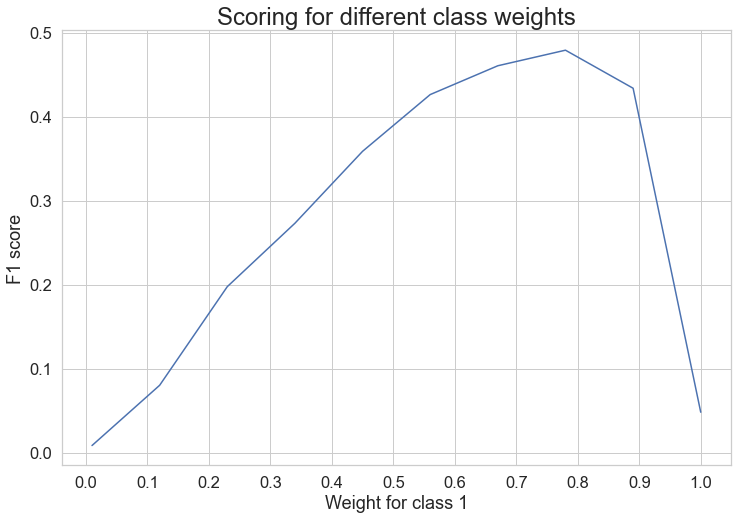

In [12]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_X, train_y)

#Ploting the score for different values of weight
sn.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sn.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
# Get the index of the highest F1 score
best_index = gridsearch.best_index_

# Get the corresponding weight values for weight one and weight two
best_weight_one = 1 - weights[best_index]
best_weight_two = weights[best_index]

# Get the highest F1 score
best_f1_score = gridsearch.cv_results_['mean_test_score'][best_index]

# Print the results
print("Highest F1 Score:", best_f1_score)
print("Weight for Class 1:", best_weight_one)
print("Weight for Class 2:", best_weight_two)

Nowy model dla nowych wag

The f1 score for the testing data: 0.4702549575070821


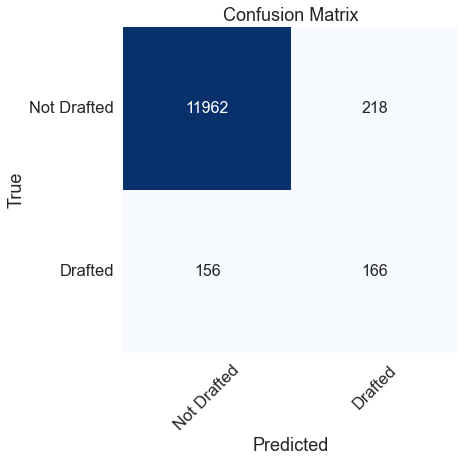

In [57]:
# create logistic regression model with balanced class weights
model = LogisticRegression(solver='newton-cg', class_weight={0: 0.22, 1: 0.78})

# fit the model on the training data
model.fit(train_X, train_y)

# make predictions on the validation set
pred_test = model.predict(val_X)

# calculate f1 score and plot confusion matrix
f1_test = f1_score(val_y, pred_test)
print('The f1 score for the testing data:', f1_test)
# Calculate class weights for minority and majority classes
conf_matrix(val_y, pred_test)

Validation f1 score: 0.39306
Validation recall score: 0.69388
Validation presision score: 0.27419


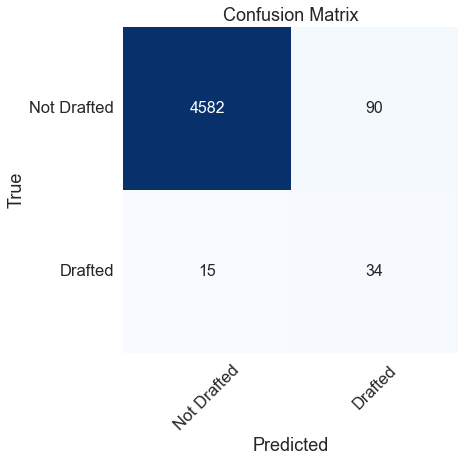

In [16]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

Check importance of features in Logistic Regression Model

    Feature     Score
0       0.0  0.006293
1       1.0  0.003362
2       2.0  0.028659
3       3.0  0.006821
4       4.0  0.013423
5       5.0  0.014656
6       6.0  0.002325
7       7.0  0.005046
8       8.0  0.003604
9       9.0  0.012563
10     10.0 -0.005341
11     11.0 -0.005844
12     12.0  0.000171
13     13.0 -0.006818
14     14.0 -0.009276
15     15.0  0.000131
16     16.0 -0.000903
17     17.0 -0.000739
18     18.0  0.000049
19     19.0  0.000554
20     20.0  0.000810
21     21.0  0.014422
22     22.0 -0.000507
23     23.0  0.024138
24     24.0  0.002473
25     25.0  0.000153


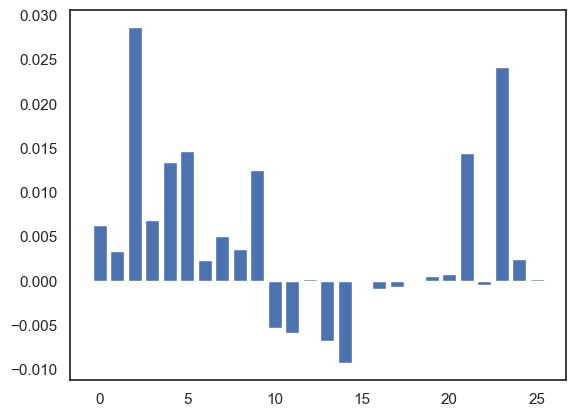

In [120]:
importance = model.coef_[0]
importancedf = pd.DataFrame(columns=['Feature', 'Score'])
# summarize feature importance
for i,v in enumerate(importance):
    importancedf = importancedf.append({'Feature':round(i), 'Score':v}, ignore_index=True)
print(importancedf)
# plot feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

Choose top 11 features with highest importance

In [123]:
featurelist = list(X)
importancedf['Score'] = importancedf['Score'].abs()
featuresdf = pd.DataFrame({'Feature': importancedf.iloc[:,0], 'Name': featurelist, '|Score|':importancedf.iloc[:,1]})
featuresdf = featuresdf.sort_values(by=['|Score|'], ascending=False)
featuresdf.head(11)

,Feature,Name,|Score|
2,2.0,Ortg,0.028659
23,23.0,adjoe,0.024138
5,5.0,TS_per,0.014656
21,21.0,ftr,0.014422
4,4.0,eFG,0.013423
9,9.0,TO_per,0.012563
14,14.0,twoPA,0.009276
3,3.0,usg,0.006821
13,13.0,twoPM,0.006818
0,0.0,GP,0.006293


## Feature Importance

In [23]:
def plot_feature_importance(model, x_train, n=55):
    # extract and sort the feature importance
    features = model.coef_[0]
    feature_names = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, feature_names])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
    sn.set(font_scale=1)
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

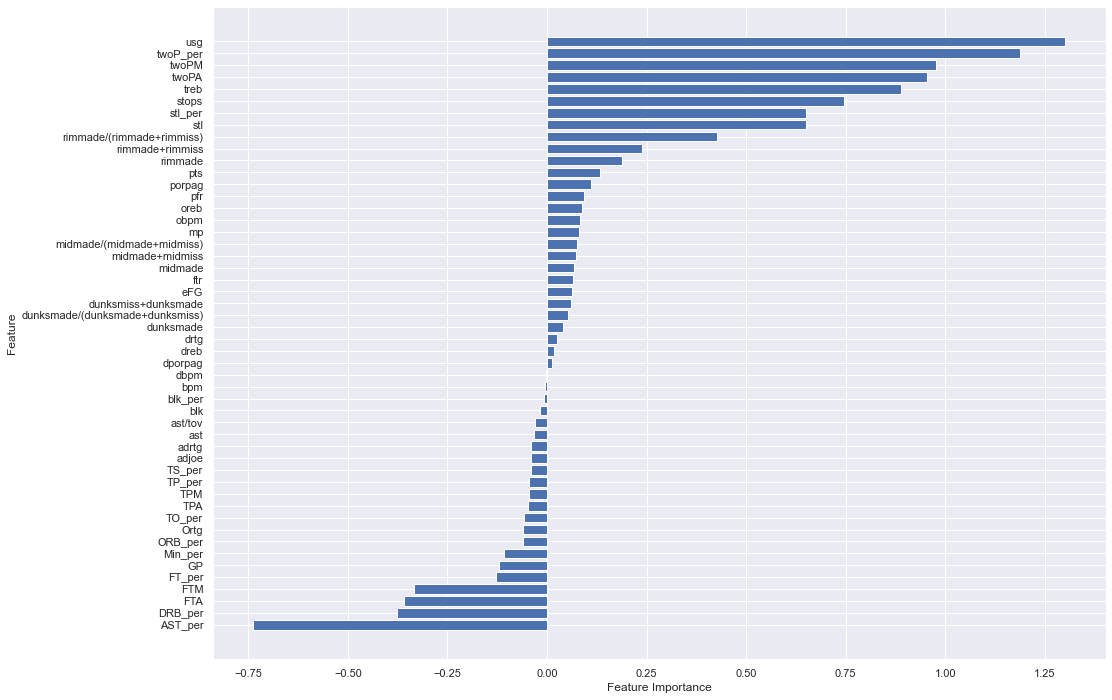

In [26]:
plot_feature_importance(model, train_X)

SelectFromModel

In [27]:
for i in [5,7,9,11]:
    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    print(len(selected_feat))
    print(list(selected_feat))
    #pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    # Fit the model
    model.fit(train_XX, train_y)
    y_pred = model.predict(val_XX)
    f1 = f1_score(val_y, y_pred)
    recall = recall_score(val_y, y_pred)
    precision = precision_score(val_y, y_pred)
    print("Validation f1 score: {:,.5f}".format(f1))
    print("Validation recall score: {:,.5f}".format(recall))
    print("Validation precision score: {:,.5f}".format(precision))
    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]
    # Make predictions
    test_preds_2021 = model.predict(test_X_2021)
    f1 = f1_score(ball_data_2021.pick, test_preds_2021)
    recall = recall_score(ball_data_2021.pick, test_preds_2021)
    precision = precision_score(ball_data_2021.pick, test_preds_2021)
    print("2021 f1 score: {:,.5f}".format(f1))
    print("2021 recall score: {:,.5f}".format(recall))
    print("2021 presision score: {:,.5f}".format(precision))

    # Save predictions in right format
    #output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
    #output.to_csv('predictions2021.csv', index=False)
    #output = output.astype({'Pick':'int'})
    #output = output.astype({'Actual Pick':'int'})
    #output


5
['FT_per', 'twoP_per', 'rimmade/(rimmade+rimmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'stl']
Validation f1 score: 0.11622
Validation recall score: 0.07453
Validation precision score: 0.26374
2021 f1 score: 0.07692
2021 recall score: 0.06122
2021 presision score: 0.10345
7
['FT_per', 'twoP_per', 'TP_per', 'rimmade/(rimmade+rimmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'dporpag', 'stl']
Validation f1 score: 0.37718
Validation recall score: 0.36957
Validation precision score: 0.38511
2021 f1 score: 0.33333
2021 recall score: 0.46939
2021 presision score: 0.25843
9
['FT_per', 'twoP_per', 'TP_per', 'rimmade/(rimmade+rimmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'dporpag', 'ast', 'stl', 'blk']
Validation f1 score: 0.37718
Validation recall score: 0.36957
Validation precision score: 0.38511
2021 f1 score: 0.34783
2021 recall score: 0.48980
2021 presision score: 0.26966
11
['FT_per', 'twoP_per', 'TP_per', 'stl_per', 'rimmade/(rimmade+rimmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'dporpag', 

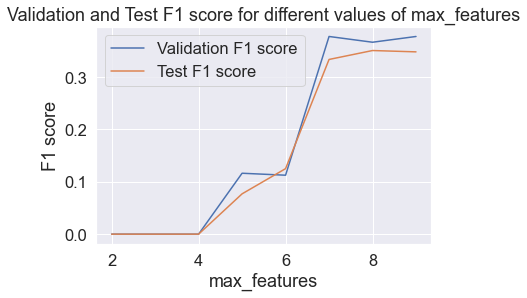

In [46]:
max_features_values = range(2,10)
val_f1_values = []
test_f1_values = []

for i in max_features_values:
    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    
    model.fit(train_XX, train_y)
    y_pred = model.predict(val_XX)
    f1 = f1_score(val_y, y_pred)
    val_f1_values.append(f1)
    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]
    test_preds_2021 = model.predict(test_X_2021)
    test_f1_2021 = f1_score(ball_data_2021.pick, test_preds_2021)
    test_f1_values.append(test_f1_2021)

plt.plot(max_features_values, val_f1_values, label='Validation F1 score')
plt.plot(max_features_values, test_f1_values, label='Test F1 score')
plt.legend()
plt.xlabel('max_features')
plt.ylabel('F1 score')
plt.title('Validation and Test F1 score for different values of max_features')
plt.show()

In [48]:
print(classification_report(val_y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12180
           1       0.39      0.37      0.38       322

    accuracy                           0.97     12502
   macro avg       0.68      0.68      0.68     12502
weighted avg       0.97      0.97      0.97     12502



### Cross Validation 

In [49]:
log_cv_score = cross_val_score(model, train_X, train_y, cv=3, scoring='f1')
mean_log_cv_score = np.mean(log_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_log_cv_score * 100))

Mean Cross Validation Score: 47.45%


In [50]:
#how well did our model predict our correct class? 
accuracy_score(val_y, y_pred)

0.9685650295952648

### Grid Search for Logistic Regression

In [52]:
log_grid_search = GridSearchCV(model, {'C':[0.001,.009,0.01,.09,1,5,10,25,45]}, cv=3, return_train_score=True)
log_grid_search.fit(train_X,train_y)
log_gs_training_score = np.mean(log_grid_search.cv_results_['mean_train_score'])
print(log_gs_training_score, 'training')
log_gs_testing_score = log_grid_search.score(train_X, train_y)

#Predict values based on new parameters
y_pred_acc = log_grid_search.predict(val_X)

# New Model Evaluation metrics 
print("Mean Training Score:", log_gs_training_score*100)
print("Mean Testing Score:", log_gs_testing_score*100)
print('Accuracy Score : ' + str(accuracy_score(val_y,y_pred_acc)))
print('Precision Score : ' + str(precision_score(val_y,y_pred_acc)))
print('Recall Score : ' + str(recall_score(val_y,y_pred_acc)))
print('F1 Score : ' + str(f1_score(val_y,y_pred_acc)))
print("Best Parameter Found:")
log_grid_search.best_params_

0.9717911607942017 training
Mean Training Score: 97.17911607942017
Mean Testing Score: 97.23496160409556
Accuracy Score : 0.9700847864341705
Precision Score : 0.42613636363636365
Recall Score : 0.4658385093167702
F1 Score : 0.44510385756676557
Best Parameter Found:


{'C': 0.001}

### ROC AUC GRAPH

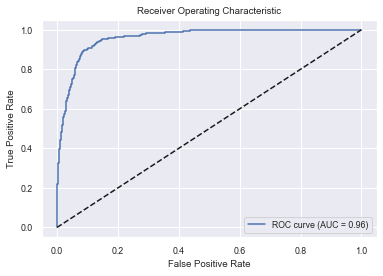

In [58]:
#test set
# Obtain predicted probabilities for positive class
probs = model.predict_proba(val_X)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(val_y, probs)

# Calculate ROC AUC
roc_auc = roc_auc_score(val_y, probs)
sn.set(font_scale=0.8)
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()